# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Normal)

In [1]:
# set up path to doogle drive folder with weights
weights_path = '/content/drive/MyDrive/Uni/MA/model_weights/'

##### Notebook settings

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Install packages

In [3]:
!pip -q install 'tensorflow-privacy==0.5.2'
#!pip -q install git+https://github.com/tensorflow/privacy #TODO fix this

     |████████████████████████████████| 194kB 8.0MB/s 


##### Import libraries

In [4]:
import os, random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.layers import Layer, Input, InputLayer, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, Flatten

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.analysis.compute_noise_from_budget_lib import compute_noise
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import VectorizedDPKerasAdamOptimizer

#import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia

##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
[Paper 1](https://ieeexplore.ieee.org/document/9144185)
[Paper 2](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [5]:
if not os.path.exists('COVID-19_Radiography_Dataset'):
    !gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
    !unzip -q COVID-19_Radiography_Database.zip
    !rm COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Database.zip
780MB [00:03, 197MB/s]


##### Define constants

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data parameters
TEST_SPLIT = 0.15
VAL_SPLIT = 0.1
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 32
IMG_SHAPE = [256, 256, 3] # original dataset image size is 299x299x3
EPOCHS = 20

# DP-SGD parameters
NOISE_MULTIPLIER = 0.86
L2_NORM_CLIP = 1.0
MICROBATCHES = BATCH_SIZE

# Set fixed random seed
SEED = 42
random.seed(SEED)
random_state = SEED
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data


### Create dataset

In [7]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [8]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [9]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    random.shuffle(covid_images)
    covid_images = covid_images[:int(len(covid_images))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))]
    random.shuffle(normal_images)
    normal_images = normal_images[:int(IMBALANCE_RATIO*len(covid_images))]
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [10]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [11]:
# create train-test split
x_train, x_test, y_train, y_test = train_test_split(files, labels, test_size=TEST_SPLIT, random_state=random_state)
x_train, x_val, y_train, y_val = train_test_split(files, labels, test_size=VAL_SPLIT, random_state=random_state)

In [12]:
TRAIN_IMG_COUNT = len(y_train)
VAL_IMG_COUNT = len(y_val)
TEST_IMG_COUNT = len(y_test)
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Val: ' + str(VAL_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 8136, Val: 904, Test: 1356


In [13]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [14]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
VAL_DISTRIBUTION = get_distribution(y_val)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('val set: ', VAL_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 4883, 'COVID-19': 3253}
val set:  {'normal': 541, 'COVID-19': 363}
test set:   {'normal': 817, 'COVID-19': 539}


###### Create tensors

In [15]:
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_files = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [16]:
def get_img(x, y):
    path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [17]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
val_ds = val_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

### Prepare for training

###### Define preprocessing

In [18]:
preprocessing = Sequential([
  Resizing(IMG_SHAPE[0], IMG_SHAPE[1]),
  Rescaling(scale=1./255)
])

###### Define data augmentation

In [19]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [20]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [21]:
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare batches

In [22]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        if str(batch) == '1':
            ds = ds.batch(batch).prefetch(buffer_size=AUTOTUNE)
        else:
            ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [23]:
# batch datasets
train_batched = prepare_dataset(train_ds,
                                pre=True,
                                shuffle=True,
                                repeat=True,
                                batch=True,
                                augment=True,
                                cache='./data.tfcache')
val_batched = prepare_dataset(val_ds,
                              pre=True,
                              shuffle=False,
                              repeat=False,
                              batch=True,
                              augment=False)
test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

In [24]:
# seperate train labels and images for attacks
train_unbatched= prepare_dataset(train_ds,
                                 pre=True,
                                 shuffle=True,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_train_attack = prepare_dataset(train_unbatched,
                                 pre=False,
                                 shuffle=False,
                                 repeat=False,
                                 batch=1,
                                 augment=False)
y_train_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(train_unbatched):
    y_train_attack.append(y)

# seperate test labels and images for attacks
test_unbatched = prepare_dataset(test_ds,
                                 pre=True,
                                 shuffle=False,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_test_attack = prepare_dataset(test_unbatched,
                                pre=False,
                                shuffle=False,
                                repeat=False,
                                batch=1,
                                augment=False)

y_test_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(test_unbatched):
    y_test_attack.append(y)

### Visualization

###### Distribution of labels in the sets

In [25]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

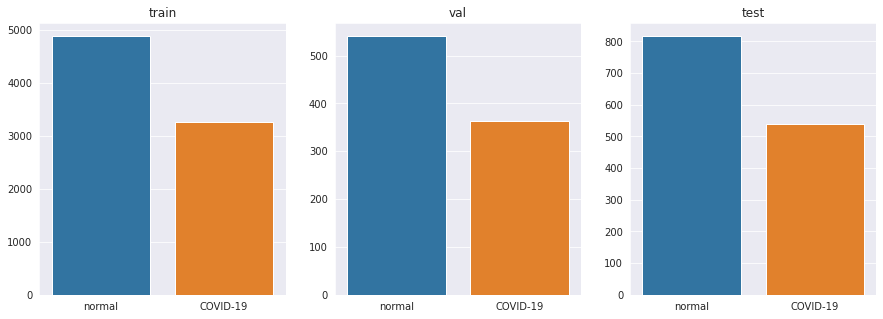

In [26]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'val': VAL_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [27]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [28]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


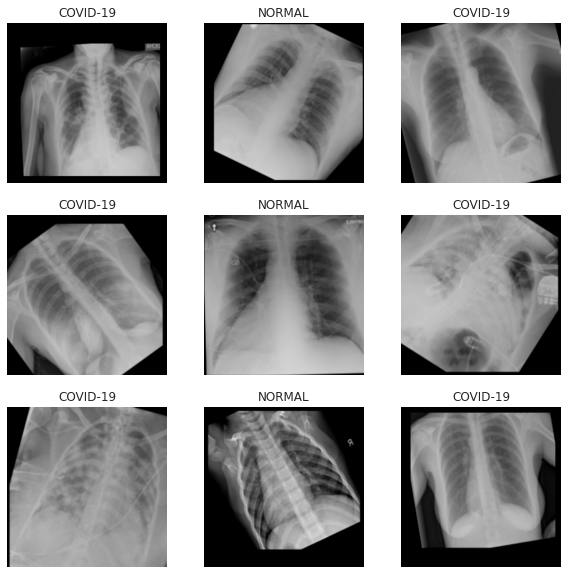

In [29]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

###### Define class weights

In [30]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())

print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.25


### Learning rate decay

In [31]:
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=1e-6)

## DP-Net - relu
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [32]:
def dpnet_relu_builder():
    # create DP-Net
    dpnet = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='valid', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='valid', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(units=32, activation='relu'),
        BatchNormalization(),
        Dense(units=1, activation='sigmoid'),
    ], name='DP-Net-relu')
    return dpnet

In [33]:
dpnet_relu = dpnet_relu_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

dpnet_relu.compile(
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [34]:
dpnet_relu.summary()

Model: "DP-Net-relu"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 125, 16)      3088      
_________________________________________________________________
batch_normalization (BatchNo (None, 125, 125, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              

### Training

In [35]:
history_dpnet_relu = dpnet_relu.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4982: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


254/254 [==============================] - 163s 505ms/step - loss: 0.8821 - accuracy: 0.5634 - precision: 0.4656 - recall: 0.5563 - val_loss: 0.9399 - val_accuracy: 0.5826 - val_precision: 0.4891 - val_recall: 0.8116
Epoch 2/20
254/254 [==============================] - 120s 472ms/step - loss: 0.9862 - accuracy: 0.6227 - precision: 0.5276 - recall: 0.6108 - val_loss: 0.9236 - val_accuracy: 0.6362 - val_precision: 0.6074 - val_recall: 0.2742
Epoch 3/20
254/254 [==============================] - 121s 478ms/step - loss: 0.9774 - accuracy: 0.6431 - precision: 0.5495 - recall: 0.6351 - val_loss: 0.9456 - val_accuracy: 0.6696 - val_precision: 0.5708 - val_recall: 0.7258
Epoch 4/20
254/254 [==============================] - 121s 476ms/step - loss: 0.9196 - accuracy: 0.6569 - precision: 0.5645 - recall: 0.6360 - val_loss: 0.8375 - val_accuracy: 0.6897 - val_precision: 0.5874 - val_recall: 0.7729
Epoch 5/20
254/254 [==============================] - 121s 477ms/step - loss: 0.8810 - accuracy: 0.

### Evaluation

###### Visualize performance

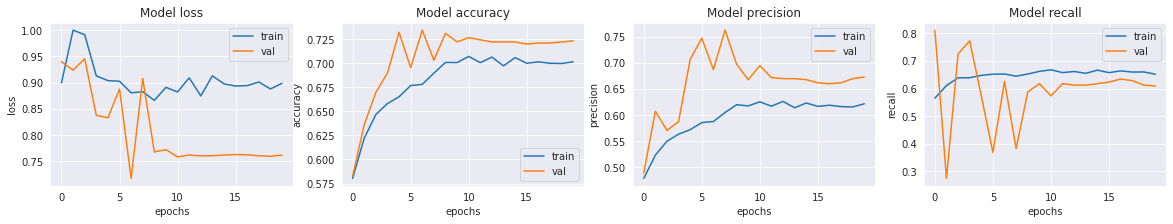

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_dpnet_relu.history[met])
    ax[i].plot(history_dpnet_relu.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [37]:
loss, acc, prec, rec = dpnet_relu.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 3s 65ms/step - loss: 0.7655 - accuracy: 0.7360 - precision: 0.6921 - recall: 0.6048
Loss of the model is -  0.7655332088470459
Accuracy of the model is -  73.5988199710846 %
Precision of the model is -  0.6921443939208984
Recall of the model is -  0.6048237681388855


## DP-Net - CNN Architecture for DP-SGD
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [38]:
def dpnet_builder():
    # create DP-Net
    dpnet = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='valid', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='valid', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(units=32, activation='tanh'),
        BatchNormalization(),
        Dense(units=1, activation='sigmoid'),
    ], name='DP-Net')
    return dpnet

In [39]:
dpnet = dpnet_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

dpnet.compile(  
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [40]:
dpnet.summary()

Model: "DP-Net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 125, 125, 16)      3088      
_________________________________________________________________
batch_normalization_3 (Batch (None, 125, 125, 16)      64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)              0    

### Training

In [41]:
history_dpnet = dpnet.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4982: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


254/254 [==============================] - 128s 476ms/step - loss: 0.9771 - accuracy: 0.5767 - precision: 0.4799 - recall: 0.5949 - val_loss: 1.0997 - val_accuracy: 0.6596 - val_precision: 0.5519 - val_recall: 0.8255
Epoch 2/20
254/254 [==============================] - 120s 474ms/step - loss: 1.1916 - accuracy: 0.6632 - precision: 0.5709 - recall: 0.6647 - val_loss: 1.3078 - val_accuracy: 0.6786 - val_precision: 0.5729 - val_recall: 0.7950
Epoch 3/20
254/254 [==============================] - 121s 477ms/step - loss: 1.1570 - accuracy: 0.6703 - precision: 0.5802 - recall: 0.6600 - val_loss: 0.9045 - val_accuracy: 0.6964 - val_precision: 0.6395 - val_recall: 0.5651
Epoch 4/20
254/254 [==============================] - 119s 470ms/step - loss: 1.1059 - accuracy: 0.6717 - precision: 0.5820 - recall: 0.6549 - val_loss: 1.0359 - val_accuracy: 0.6763 - val_precision: 0.5794 - val_recall: 0.7175
Epoch 5/20
254/254 [==============================] - 120s 472ms/step - loss: 1.1027 - accuracy: 0.

### Evaluation

###### Visualize performance

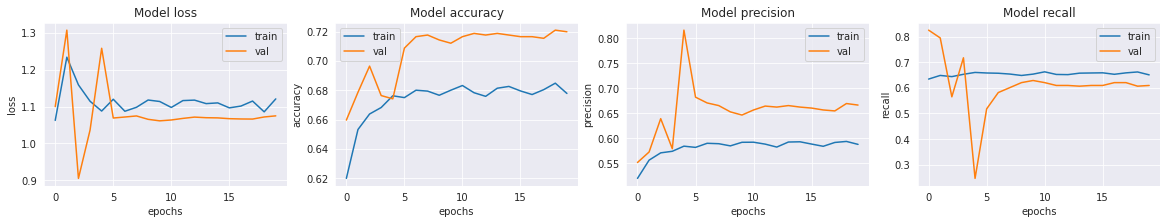

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_dpnet.history[met])
    ax[i].plot(history_dpnet.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [43]:
loss, acc, prec, rec = dpnet.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 1s 30ms/step - loss: 1.0573 - accuracy: 0.7183 - precision: 0.6605 - recall: 0.5993
Loss of the model is -  1.057287335395813
Accuracy of the model is -  71.82890772819519 %
Precision of the model is -  0.6605316996574402
Recall of the model is -  0.5992578864097595


## DP-Net - logits
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [44]:
def dpnet_logits_builder():
    # create DP-Net
    dpnet = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='valid', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='valid', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(units=32, activation='tanh'),
        BatchNormalization(),
        Dense(units=1, activation='sigmoid'),
    ], name='DP-Net-logits')
    return dpnet

In [45]:
dpnet_logits = dpnet_logits_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

dpnet_logits.compile(  
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=False,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [46]:
dpnet_logits.summary()

Model: "DP-Net-logits"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 125, 125, 16)      3088      
_________________________________________________________________
batch_normalization_6 (Batch (None, 125, 125, 16)      64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7200)            

### Training

In [47]:
history_dpnet_logits = dpnet_logits.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20
254/254 [==============================] - 128s 479ms/step - loss: 0.8779 - accuracy: 0.6317 - precision: 0.5319 - recall: 0.6250 - val_loss: 1.4484 - val_accuracy: 0.5737 - val_precision: 0.4835 - val_recall: 0.8532
Epoch 2/20
254/254 [==============================] - 120s 473ms/step - loss: 1.0765 - accuracy: 0.6709 - precision: 0.5740 - recall: 0.6879 - val_loss: 1.4092 - val_accuracy: 0.6261 - val_precision: 0.5225 - val_recall: 0.8366
Epoch 3/20
254/254 [==============================] - 121s 478ms/step - loss: 1.1347 - accuracy: 0.6714 - precision: 0.5755 - recall: 0.6773 - val_loss: 1.2497 - val_accuracy: 0.6652 - val_precision: 0.5624 - val_recall: 0.7618
Epoch 4/20
254/254 [==============================] - 121s 476ms/step - loss: 1.0458 - accuracy: 0.6757 - precision: 0.5814 - recall: 0.6660 - val_loss: 0.9685 - val_accuracy: 0.7009 - val_precision: 0.7246 - val_recall: 0.4155
Epoch 5/20
254/254 [==============================] - 119s 468ms/step - loss: 1.0528 - a

### Evaluation

###### Visualize performance

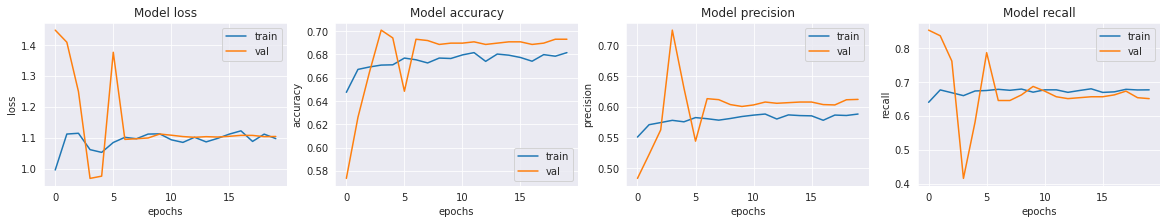

In [48]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_dpnet_logits.history[met])
    ax[i].plot(history_dpnet_logits.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [49]:
loss, acc, prec, rec = dpnet_logits.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 1s 30ms/step - loss: 1.0842 - accuracy: 0.7050 - precision: 0.6209 - recall: 0.6623
Loss of the model is -  1.0841749906539917
Accuracy of the model is -  70.50147652626038 %
Precision of the model is -  0.6208695769309998
Recall of the model is -  0.6623376607894897


## DP-Net nobn
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [50]:
def dpnet_nobn_builder():
    # create DP-Net
    dpnet = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='valid', activation='tanh'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='valid', activation='tanh'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(units=32, activation='tanh'),
        Dense(units=1, activation='sigmoid'),
    ], name='DP-Net-nobn')
    return dpnet

In [51]:
dpnet_nobn = dpnet_nobn_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

dpnet_nobn.compile(  
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [52]:
dpnet_nobn.summary()

Model: "DP-Net-nobn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 125, 125, 16)      3088      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                230432    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 

### Training

In [53]:
history_dpnet_nobn = dpnet_nobn.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4982: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


254/254 [==============================] - 109s 412ms/step - loss: 1.5057 - accuracy: 0.5876 - precision: 0.2306 - recall: 0.0048 - val_loss: 1.3779 - val_accuracy: 0.5971 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
254/254 [==============================] - 103s 408ms/step - loss: 1.6976 - accuracy: 0.5945 - precision: 0.4980 - recall: 2.0951e-04 - val_loss: 1.3767 - val_accuracy: 0.5971 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
254/254 [==============================] - 104s 409ms/step - loss: 1.7195 - accuracy: 0.5975 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5454 - val_accuracy: 0.5971 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
254/254 [==============================] - 104s 409ms/step - loss: 1.7426 - accuracy: 0.5990 - precision: 0.3529 - recall: 1.5185e-04 - val_loss: 1.4627 - val_accuracy: 0.5971 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
254/254 [==============================]

### Evaluation

###### Visualize performance

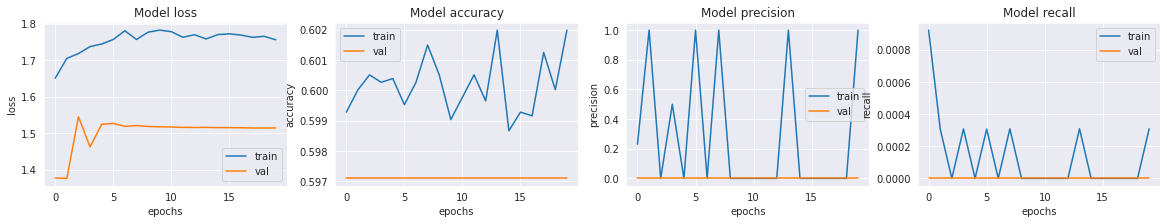

In [54]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_dpnet_nobn.history[met])
    ax[i].plot(history_dpnet_nobn.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [55]:
loss, acc, prec, rec = dpnet_nobn.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 1s 29ms/step - loss: 1.5035 - accuracy: 0.6025 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss of the model is -  1.5035141706466675
Accuracy of the model is -  60.25073528289795 %
Precision of the model is -  0.0
Recall of the model is -  0.0


## DP-Net pneu
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [56]:
def dpnet_pneu_builder():
    # create DP-Net
    dpnet = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='valid', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='valid', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(units=32, activation='tanh'),
        BatchNormalization(),
        Dense(units=1, activation='sigmoid'),
    ], name='DP-Net-pneu')
    return dpnet

In [57]:
dpnet_pneu = dpnet_pneu_builder()

# load weights from pneumonia pretraining
dpnet_pneu.load_weights(weights_path+'dpnet_tanh_public_weights.h5')

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

dpnet_pneu.compile(  
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [58]:
dpnet_pneu.summary()

Model: "DP-Net-pneu"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 125, 125, 16)      3088      
_________________________________________________________________
batch_normalization_9 (Batch (None, 125, 125, 16)      64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
batch_normalization_10 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 7200)              

### Training

In [59]:
history_dpnet_pneu = dpnet_pneu.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4982: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


254/254 [==============================] - 128s 477ms/step - loss: 0.9212 - accuracy: 0.6576 - precision: 0.5534 - recall: 0.7740 - val_loss: 3.1731 - val_accuracy: 0.4453 - val_precision: 0.4196 - val_recall: 0.9834
Epoch 2/20
254/254 [==============================] - 120s 475ms/step - loss: 1.1046 - accuracy: 0.6794 - precision: 0.5741 - recall: 0.7696 - val_loss: 2.9222 - val_accuracy: 0.4665 - val_precision: 0.4271 - val_recall: 0.9501
Epoch 3/20
254/254 [==============================] - 120s 472ms/step - loss: 1.2222 - accuracy: 0.6801 - precision: 0.5770 - recall: 0.7630 - val_loss: 1.2908 - val_accuracy: 0.6797 - val_precision: 0.6888 - val_recall: 0.3740
Epoch 4/20
254/254 [==============================] - 120s 474ms/step - loss: 1.1884 - accuracy: 0.6770 - precision: 0.5725 - recall: 0.7695 - val_loss: 2.0972 - val_accuracy: 0.6127 - val_precision: 0.6061 - val_recall: 0.1108
Epoch 5/20
254/254 [==============================] - 119s 470ms/step - loss: 1.1546 - accuracy: 0.

### Evaluation

###### Visualize performance

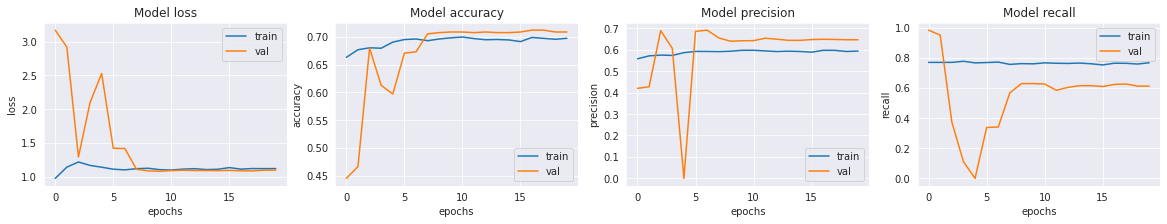

In [60]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_dpnet_pneu.history[met])
    ax[i].plot(history_dpnet_pneu.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [61]:
loss, acc, prec, rec = dpnet_pneu.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 1s 29ms/step - loss: 1.0836 - accuracy: 0.7161 - precision: 0.6469 - recall: 0.6289
Loss of the model is -  1.0835564136505127
Accuracy of the model is -  71.6076672077179 %
Precision of the model is -  0.6469465494155884
Recall of the model is -  0.6289424896240234


## Evaluation

In [62]:
models = [
    dpnet_relu,
    dpnet,
    dpnet_logits,
    dpnet_nobn,
    dpnet_pneu,
]

### Model Analysis

In [63]:
for model in models:
    print("Evaluating %s ..." % (model.name))
    loss, acc, prec, rec = model.evaluate(test_batched)
    print('\n')

Evaluating DP-Net-relu ...
43/43 [==============================] - 1s 29ms/step - loss: 0.7655 - accuracy: 0.7360 - precision: 0.6921 - recall: 0.6048


Evaluating DP-Net ...
43/43 [==============================] - 1s 29ms/step - loss: 1.0573 - accuracy: 0.7183 - precision: 0.6605 - recall: 0.5993


Evaluating DP-Net-logits ...
43/43 [==============================] - 1s 29ms/step - loss: 1.0842 - accuracy: 0.7050 - precision: 0.6209 - recall: 0.6623


Evaluating DP-Net-nobn ...
43/43 [==============================] - 1s 28ms/step - loss: 1.5035 - accuracy: 0.6025 - precision: 0.0000e+00 - recall: 0.0000e+00


Evaluating DP-Net-pneu ...
43/43 [==============================] - 1s 29ms/step - loss: 1.0836 - accuracy: 0.7161 - precision: 0.6469 - recall: 0.6289




### Privacy Analysis

#### Compute epsilon

In [64]:
# delta rule of thumb: set to less than the inverse of the training data size
DELTA = 1e-4

In [65]:
# computes epsilon for given hyperparameters
def compute_epsilon(n, batch_size, noise_multiplier, epochs, delta):
    if noise_multiplier == 0.0:
        return float('inf')
    sampling_probability = batch_size / n
    steps = int(np.ceil(epochs * n / batch_size))
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(
        q = sampling_probability,
        noise_multiplier = noise_multiplier,
        steps = steps,
        orders = orders)
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [66]:
eps = compute_epsilon(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    NOISE_MULTIPLIER,
    EPOCHS,
    DELTA)
print('Delta = %.e, Epsilon = %.3f'%(DELTA, eps))

Delta = 1e-04, Epsilon = 1.998


In [67]:
# get needed noise for target epsilon
min_noise = 1e-5
target_epsilon = 2.0
noise = compute_noise(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    target_epsilon,
    EPOCHS,
    DELTA,
    min_noise
)
print(noise)

DP-SGD with sampling rate = 0.393% and noise_multiplier = 0.8609074254167081 iterated over 5085 steps satisfies differential privacy with eps = 2 and delta = 0.0001.
0.8609074254167081


#### Membership Inference Attack

In [68]:
# run membership inference attack
def run_mia(model, x_train_attack, x_test_attack, y_train_attack, y_test_attack):
    # predict on train
    probs_train = model.predict(x_train_attack)
    # predict on test
    probs_test = model.predict(x_test_attack)

    # only label as output instead of prob
    #probs_train = np.round(logits_train)
    #probs_test = np.round(logits_test)

    # compute losses
    bc = tf.keras.backend.binary_crossentropy
    constant = tf.keras.backend.constant

    loss_train = np.array([x[0] for x in bc(constant([[y] for y in y_train_attack]), constant(probs_train), from_logits=False).numpy()])
    loss_test = np.array([x[0] for x in bc(constant([[y] for y in y_test_attack]), constant(probs_test), from_logits=False).numpy()])

    # labels
    train_labels = np.array(y_train_attack)
    test_labels = np.array(y_test_attack)

    # prepare attacks
    attack_input = AttackInputData(
        probs_train = probs_train,
        probs_test = probs_test,
        loss_train = loss_train,
        loss_test = loss_test,
        labels_train = train_labels,
        labels_test = test_labels
    )

    slicing_spec = SlicingSpec(
        entire_dataset = True,
        by_class = True,)

    attack_types = [
        AttackType.THRESHOLD_ATTACK,
        AttackType.LOGISTIC_REGRESSION,
    ] 

    # run several attacks for different data slices
    attacks_result = mia.run_attacks(attack_input=attack_input,
                                     slicing_spec=slicing_spec,
                                     attack_types=attack_types)

    # plot the ROC curve of the best classifier
    plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)
    plt.show()

    # print a user-friendly summary of the attacks
    print(attacks_result.summary(by_slices=False)) #TODO fix low auc sometimes

Membership Inference Attack on DP-Net-relu...
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier


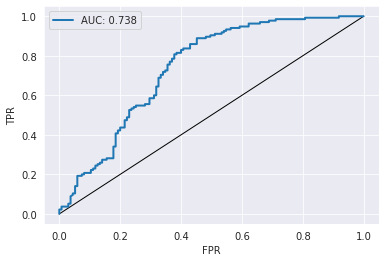

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an AUC of 0.74 on slice CLASS=1
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an advantage of 0.44 on slice CLASS=1


Membership Inference Attack on DP-Net...
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier


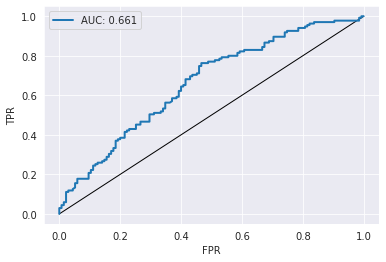

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an AUC of 0.66 on slice CLASS=1
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an advantage of 0.30 on slice CLASS=1


Membership Inference Attack on DP-Net-logits...
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier


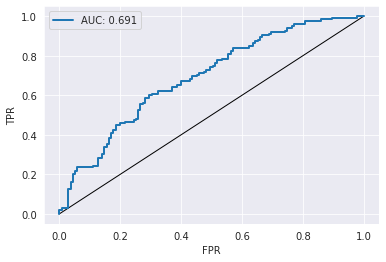

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an AUC of 0.69 on slice CLASS=1
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an advantage of 0.30 on slice CLASS=1


Membership Inference Attack on DP-Net-nobn...
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier


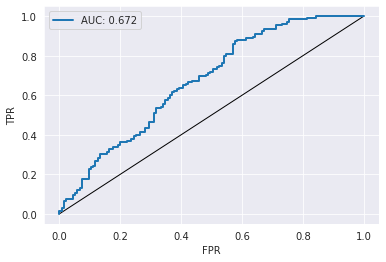

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an AUC of 0.67 on slice CLASS=1
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an advantage of 0.30 on slice CLASS=1


Membership Inference Attack on DP-Net-pneu...
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier


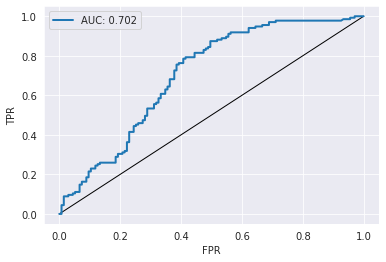

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an AUC of 0.70 on slice CLASS=1
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an advantage of 0.38 on slice CLASS=1




In [69]:
for model in models:
    print('Membership Inference Attack on '+model.name+'...')
    run_mia(model, x_train_attack, x_test_attack, y_train_attack, y_test_attack)
    print('\n')